# **StyleGAN3 + AudioCLIP 🖼️**

## Generate images from audio prompts using NVIDIA's StyleGAN3 with AudioCLIP guidance.

<!-- Head over [here](https://github.com/ouhenio/StyleGAN3-CLIP-notebook) if you want to be up to date with the changes to this notebook and play with other alternatives.

The original code was written by [nshepperd](https://twitter.com/nshepperd1)* (https://github.com/nshepperd), and later edited by [Eugenio Herrera](https://github.com/ouhenio).

Thanks to [Katherine Crowson](https://twitter.com/RiversHaveWings) (https://github.com/crowsonkb) for coming up with many improved sampling tricks, as well as some of the code.

----

(*) nshepperd originally made [this notebook](https://colab.research.google.com/drive/1eYlenR1GHPZXt-YuvXabzO9wfh9CWY36#scrollTo=LQf7tzBQ8rn2).

(**) The interface is inspired by [this notebook](https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP(Updated).ipynb), done by Jakeukalane and Avengium (Angel).

(***) For more information about StyleGAN3, [visit the official repository](https://github.com/NVlabs/stylegan3). -->

In [1]:
!nvidia-smi

Tue May 10 23:09:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
|  0%   43C    P8    32W / 370W |     10MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:68:00.0  On |                  N/A |
|  0%   

In [3]:
# DOWNLOAD AND IMPORT EVERYTHING

# !pip install kornia pytorch-ignite visdom ftfy
# !pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
# !git clone https://github.com/NVlabs/stylegan3
# !git clone https://github.com/russelldc/AudioCLIP AudioCLIP
# !wget --continue https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/AudioCLIP-Partial-Training.pt ./weights/
# !pip install einops ninja librosa termcolor numpy\<1.21

import sys
sys.path.append('./AudioCLIP')
sys.path.append('./stylegan3')
sys.path.append('.')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from audioclip import AudioCLIP
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
import IPython.display as disp
from einops import rearrange
from google.colab import files
import random
import math
import time
from abc import ABC, abstractmethod
import json
import pyaudio
import wave
import dill
from torch.multiprocessing import Process, set_start_method
from threading import Thread
# import multiprocessing as mp
import torch.multiprocessing as mp

device = torch.device('cuda:1')
cpu = torch.device('cpu')
print('Using device:', device, file=sys.stderr)

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

/home/carlos/miniconda3/envs/ganvis/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
Using device: cuda:1


In [3]:
# HELPERS

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path: 
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

In [4]:
# DEFINE CUTOUT HELPER AND AUDIO CLIP AND GAN CLASSES
    
class Audio_CLIP():
    def __init__(self):
        torch.set_grad_enabled(False)
        self.model = AudioCLIP(pretrained='AudioCLIP-Partial-Training.pt').to(device)
        self.model.eval()
        torch.set_grad_enabled(True)
        self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                              std=[0.26862954, 0.26130258, 0.27577711])

    def norm1(self, prompt):
        "Normalize to the unit sphere."
        return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()
    
    @torch.no_grad()
    def embed_audio(self, audio):
        "Normalized clip audio embedding."
        return self.norm1(self.model.create_audio_encoding(audio))

    @torch.no_grad()
    def embed_audio_from_raw(self, audio):
        audio = audio[:, np.newaxis]
        audio = audio.T
        audio = torch.from_numpy(audio).float().to(device)
        with torch.no_grad():
            audio_encoding = self.model.encode_audio(audio).detach()
            # print("audio enc inner shape: ", audio_encoding.shape)
        return self.norm1(audio_encoding)
    
    def embed_cutout(self, image):
        "Normalized clip image embedding."
        return self.norm1(self.model.encode_image(self.normalize(image)))

    @torch.no_grad()    
    def embed_text(self, text):
        return self.norm1(self.model.encode_text(text))
    
################################################################################################
class GanVis(torch.nn.Module):
    def __init__(self, stylegan, audio_clip, make_cutouts):
        super().__init__()
        self.stylegan = stylegan
        self.audio_clip = audio_clip
        self.make_cutouts = make_cutouts
        self.w_stds = self.compute_w_stds()
        
    def forward(self):
        G = self.stylegan
        img = G.synthesis(self.q * self.w_stds + G.mapping.w_avg, noise_mode='const')
        embed = self.embed_image(img.add(1).div(2))
        loss = self.compute_loss(embed)
        return loss
    
    def set_embeddings(self, audios, texts):
        self.audio_embeds = [self.audio_clip.embed_audio(audio) for audio in audios]
        self.text_embeds = [self.audio_clip.embed_text([text]) for text in texts]
    
    def compute_initial_q(self, explore):
        self.explore = explore
        with torch.no_grad():
            qs = []
            losses = []
            for _ in range(self.explore):
                G = self.stylegan
                q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / self.w_stds
                #   q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None))
                images = G.synthesis(q * self.w_stds + G.mapping.w_avg)
                embeds = self.embed_image(images.add(1).div(2))
                loss = self.compute_loss(embeds).mean(0)
                i = torch.argmin(loss)
                qs.append(q[i])
                losses.append(loss[i])
            qs = torch.stack(qs)
            losses = torch.stack(losses)
            i = torch.argmin(losses)
            q = qs[i].unsqueeze(0).requires_grad_()
            self.q = q
            
    def compute_loss(self, img_embed):
            
        def spherical_dist_loss(x, y):
            x = F.normalize(x, dim=-1)
            y = F.normalize(y, dim=-1)
            return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)
            
        loss = spherical_dist_loss   
        if len(self.audio_embeds) == 1: 
            return loss(img_embed, self.audio_embeds[0])
        distances = [loss(img_embed, audio_embed) for audio_embed in self.audio_embeds]
        return torch.stack(distances, dim=-1).sum(dim=-1) 
    
    def gen_img(self, latent, noise):
        G = self.stylegan
        return G.synthesis(latent * self.w_stds + G.mapping.w_avg, noise_mode=noise)
    
    def compute_w_stds(self):
        G = self.stylegan
        zs = torch.randn([10000, G.mapping.z_dim], device=device)
        w_stds = G.mapping(zs, None).std(0)
        return w_stds
    
    def embed_image(self, img):
        n = img.shape[0]
        cutouts = self.make_cutouts(img)
        embeds = self.audio_clip.embed_cutout(cutouts)
        embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
        return embeds
        
    def embed_text(self, text):
        return self.audio_clip.embed_text(text)

In [5]:
# LOAD STYLEGAN3 PRETRAINED MODELS, CHOOSE WHICH ONE TO USE

base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"
Model = 'Wikiart' #@param ["FFHQ", "MetFaces", "AFHQv2", "cosplay", "Wikiart", "Landscapes"]
Wikiart = 'Wikiart'
AFHQv2 = 'AFHQv2'
Landscapes = 'Landscapes'
model_name = {
    "FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl",
    "MetFaces": base_url + "stylegan3-r-metfacesu-1024x1024.pkl",
    "AFHQv2": base_url + "stylegan3-t-afhqv2-512x512.pkl",
    "cosplay": "https://l4rz.net/cosplayface-snapshot-stylegan3t-008000.pkl",
    "Wikiart": "https://archive.org/download/wikiart-1024-stylegan3-t-17.2Mimg/wikiart-1024-stylegan3-t-17.2Mimg.pkl",
    "Landscapes": "https://archive.org/download/lhq-256-stylegan3-t-25Mimg/lhq-256-stylegan3-t-25Mimg.pkl"
}
network_url = model_name[Model]
with open(fetch_model(model_name[Wikiart]), 'rb') as fp:
    wiki = pickle.load(fp)['G_ema'].to(device)
with open(fetch_model(model_name[AFHQv2]), 'rb') as fp:
    AFHQv2 = pickle.load(fp)['G_ema'].to(device)
# with open(fetch_model(model_name[Landscapes]), 'rb') as fp:
#   landscapes = pickle.load(fp)['G_ema'].to(device)

In [7]:
# IF THIS HANGS, INTERRRUPT KERNEL AND RUN CELL AGAIN

G = wiki.eval()
zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)
torch.save(w_stds, 'w_stds.pt')

Setting up PyTorch plugin "bias_act_plugin"... Done.


In [9]:
# INITIALIZE MODELS AND LOAD AUDIO PATHS ########################################
stylegan = wiki
make_cutouts = MakeCutouts(224, 32, 0.5)
audio_clip = Audio_CLIP()
gan_vis = GanVis(stylegan, audio_clip, make_cutouts)
videos = os.listdir("vids/actual_vids")
second_half = videos[1500:]
print(len(second_half))
video_path = "vids/actual_vids/"


# initialize these when you want to build up new datasets by training gan_vis

# X = torch.empty((1, 1024)).to(device)
# Y = torch.empty((1, 16, 512)).to(device)

1515


In [10]:
# TESTING WHAT AUDIO ENCODINGS LOOK LIKE

for i in range(1):
    path = "vids/actual_vids/" + second_half[i]
    enc = audio_clip.model.create_audio_encoding(path)
    print(enc)

tensor([[ 0.0198, -0.0099, -0.0019,  ...,  0.0070,  0.0059,  0.0087]],
       device='cuda:1')


torch.Size([1516, 1024])
torch.Size([1516, 16, 512])
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


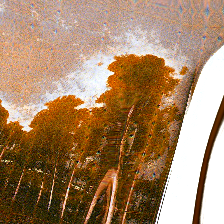

In [11]:
# TESTING DISPLAY OF IMAGES FROM TENSOR DATASETS

X = torch.load('tensorX2.pt')
print(X.shape)
Y = torch.load('tensorY2.pt')
print(Y.shape)
for i in range(0, 1, 1):
    img = gan_vis.gen_img(Y[i, :, :].reshape((1, 16, 512)), 'const')
    display(TF.to_pil_image(tf(img)[0])) 

In [19]:
# TRAIN GAN_VIS TO LEARN A GOOD Q BY MINIMIZING THE DIFFERENCE (SPHERICAL DISTANCE IN THIS CASE; BASICALLY DOT PRODUCT) BETWEEN THE GIVEN AUDIO ENCODING AND THE GENERATED IMG'ENCODING

def learn_q(epochs, lr):
    opt = torch.optim.AdamW([gan_vis.q], lr=lr, betas=(0.0,0.999))
    q_ema = gan_vis.q
    loop = tqdm(range(epochs))
    for epoch in loop:
        opt.zero_grad()
        loss = gan_vis().mean()
        loss.backward()
        opt.step()
        loop.set_postfix(loss=loss.item(), q_magnitude=gan_vis.q.std().item())
        q_ema = q_ema * 0.9 + gan_vis.q * 0.1
        # if epoch % 50 == 0:
        if epoch == epochs - 1:
            img = gan_vis.gen_img(q_ema, 'const')
            # disp.clear_output(wait=True)
            display(TF.to_pil_image(tf(img)[0]))
            print(f"Image {epoch}/{epochs} | Current loss: {loss}")
            
            # FOR SAVING IMAGES, IF NEEDED
            # pil_image = TF.to_pil_image(img[0].add(1).div(2).clamp(0,1))
            # os.makedirs(f'samples/{timestring}', exist_ok=True)
            # pil_image.save(f'samples/{timestring}/{epoch:04}.jpg')
    return q_ema

epochs = 300
lr = 0.03
seed = 14
texts = ["this is not doing anything right now"]

# OPTIMIZE FOR MANY AUDIOS

# for i in range(0, len(second_half), 1):
    # file = second_half[i]
    # torch.manual_seed(seed)
    # audios = [video_path + file]
    # try:
    #     gan_vis.set_embeddings(audios, texts)
    # except:
    #     continue
    # gan_vis.compute_initial_q()
    # try:
    #     best_q = learn_q(gan_vis_epochs, gan_vis_lr)
    #     audio_embed = gan_vis.audio_embeds[0]
    #     X = torch.cat((X, audio_embed), 0)
    #     Y = torch.cat((Y, best_q), 0)
    # except KeyboardInterrupt:
    #     pass
    # if i % 50 == 0:
    #     X_filename = 'tensorX2/X_'+str(i)+'.pt'
    #     Y_filename = 'tensorY2/Y_'+str(i)+'.pt'
    #     torch.save(X, X_filename)
    #     torch.save(Y, Y_filename)
    
# OPTIMIZE FOR SINGLE AUDIO
# audio_path = "vids/actual_vids/Lion Roaring! HD - Big Cat Rescue, Tampa FL-FWb73pA7Xu4.wav"
# torch.manual_seed(seed)
# audios = [audio_path]
# gan_vis.set_embeddings(audios, texts)
# gan_vis.compute_initial_q(20)
# q = learn_q(epochs, lr)

In [ ]:
# GENERATE FIRST IMAGE FOR DIFF EXPLORES: 1, 3, 6

audio_path = "bird_sounds.wav"
torch.manual_seed(seed)
audios = [audio_path]
gan_vis.set_embeddings(audios, texts)
for explore in [1, 3, 6]:
    print(explore)
    gan_vis.compute_initial_q(explore)
    q = learn_q(1, lr)
gan_vis.compute_initial_q(6)
learn_q(150, lr)
gan_vis.compute_initial_q(30)
learn_q(150, lr)

# CHECK COMPUTE TIME
start = time.time()
gan_vis.compute_initial_q(6)
learn_q(300, lr)
end = time.time()
print(end-start)

In [13]:
# DEFINE DIFFERENT NETWORKS TO USE FOR ESTIMATING A GOOD Q FROM A GIVEN AUDIO ENCODING
# DEFINE DATASET CLASS

class Latent(torch.nn.Module, ABC):
    def __init__(self):
        super().__init__()
        self.network = self.build_network()

    def forward(self, x):
        logits = self.network(x).reshape((-1, 16, 512))
        return logits
    
    @abstractmethod
    def build_network(self):
        pass
    
class SmallLatent(Latent): # one hidden layer
    def __init__(self):
        super().__init__()
        self.name = "small_latent"
    
    def build_network(self):
        network = torch.nn.Sequential(
            torch.nn.Linear(1024, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 8192),
        )
        return network
    
class NormalLatent(Latent): # two hidden layer
    def __init__(self):
        super().__init__()
        self.name = "normal_latent"
        
    def build_network(self):
        network = torch.nn.Sequential(
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 8192)
        )
        return network
    
class BigLatent(Latent): # three hidden layers
    def __init__(self):
        super().__init__()
        self.name = "big_latent"
    
    def build_network(self):
        network = torch.nn.Sequential(
            torch.nn.Linear(1024, 2816),
            torch.nn.ReLU(),
            torch.nn.Linear(2816, 4608),
            torch.nn.ReLU(),
            torch.nn.Linear(4608, 6400),
            torch.nn.ReLU(),
            torch.nn.Linear(6400, 8192)
        )
        return network

class HugeLatent(Latent): # five hidden layers
    def __init__(self):
        super().__init__()
        self.name = "huge_latent"
    
    def build_network(self):
        network = torch.nn.Sequential(
            torch.nn.Linear(1024, 2218),
            torch.nn.ReLU(),
            torch.nn.Linear(2218, 3412),
            torch.nn.ReLU(),
            torch.nn.Linear(3412, 4606),
            torch.nn.ReLU(),
            torch.nn.Linear(4606, 5800),
            torch.nn.ReLU(),
            torch.nn.Linear(5800, 6994),
            torch.nn.ReLU(),
            torch.nn.Linear(6994, 8192)
        )
        return network
    
class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.n_samples = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.n_samples

In [15]:
# LOAD DATA

X = torch.load('tensorX2.pt').to(device)
Y = torch.load('tensorY2.pt').to(device)
first_half_dataset = Data(X, Y)
X2 = torch.load('tensorX.pt').to(device)
Y2 = torch.load('tensorY.pt').to(device)
second_half_dataset = Data(X2, Y2)
X_full = torch.cat((X, X2), 0)
Y_full = torch.cat((Y, Y2), 0)
full_dataset = Data(X_full, Y_full)

In [14]:
# DEFINE TRAINING LOOP

def train_latent(epochs, lr, model, dataloader, alpha, stats=None):
    mae_loss = torch.nn.L1Loss()
    loss_out = 0
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    lambda1 = lambda epoch: math.exp(-alpha*epoch)
    scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1) # using this led to final loss going from .15 to .04 (def improves things but overfitting is an issue)
    loop = tqdm(range(epochs))
    for epoch in loop:
        for i, (Xbatch, Ybatch) in enumerate(dataloader):
            opt.zero_grad()
            outputs = model(Xbatch)
            l = mae_loss(outputs, Ybatch)
            l.backward()
            opt.step()
            loss_out = l.item()
            if i % 10 == 0:
                loop.set_postfix(loss=l.item(), lr=scheduler.get_last_lr())
        scheduler.step() 
        if epoch % 10 == 0:
            if stats != None:
                stats.append(loss_out)
        # if epoch % 20 == 0:
            # print(f"{epoch}/{latent_epochs} | Current loss: {l} | lr: {scheduler.get_last_lr()}")
            # print(f"{epoch}/{latent_epochs} | Current loss: {l}")

In [16]:
# TRAIN MANY MODELS, SAVE THEM, AND STATS TO JSON FILE TO COMPARE LATER

small_latent = SmallLatent().to(device) # params: [epochs=200, lr=4, sch=-.005, batchsize=32, dataset=first_1500] // final loss=0.3, train_time=1.66723475456
normal_latent = NormalLatent().to(device) # params: [epochs=200, lr=4, sch=-.005, batchsize=32, dataset=first_1500] // final loss=0.07, train_time=1.7539722045262656 min
                                          # params: [epochs=300, lr=4, sch=-.005, batchsize=32, dataset=full_3000] // final loss=, train_time =  min
big_latent = BigLatent().to(device) # params: [epochs=200, lr=4, sch=-.005, batchsize=32, dataset=first_1500] // final loss=0.04267854243516922, train_time=2.3848370869954425
                                    # params: [epochs=300, lr=4, sch=-.005, batchsize=32, dataset=full_3000] // final loss=, train_time=
huge_latent = HugeLatent().to(device) # params: [epochs=200, lr=4, sch=-.005, batchsize=32, dataset_first_1500] // final loss=0.22832874953746796, train_time=3.123041264216105
                                      # params: [epochs=300, lr=4, sch=-.005, batchsize=32, dataset=full_3000] // final loss=, train_time=

In [ ]:
# BUILD STATS DICT BY RUNNING MANY DIFFERENT CONFIGS

full_stats2 = {}
latents = [small_latent, normal_latent, big_latent]
# latents = [normal_latent, big_latent, huge_latent]
for latent in latents:
    full_stats[latent.name] = {}
    for alpha in [0.005]:
        full_stats[latent.name][alpha] = {}
        for epochs in [200, 400]:
            full_stats[latent.name][alpha][epochs] = {}
            for batch_size in [32, 64]:
                full_stats[latent.name][alpha][epochs][batch_size] = {}
                dataloader = DataLoader(dataset=sull_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                for lr in [4, 6, 8]:
                    full_stats[latent.name][alpha][epochs][batch_size][lr] = []
                    stats = []
                    print("RUNNING USING: ", latent.name)
                    print("LR: ", lr)
                    print("BATCH_SIZE: ", batch_size)
                    start = time.time()
                    train_latent(epochs, lr, latent, dataloader, alpha, stats)
                    end = time.time()
                    min_elapsed = (end-start)/60
                    print("TIME :", (end-start)/60)
                    full_stats[latent.name][alpha][epochs][batch_size][lr].append([min_elapsed, stats])
                    path = "models/" + latent.name + "_" + str(alpha) + "_" + str(epochs) + "_" + str(batch_size) + "_" + str(lr) + ".pt" 
                    torch.save(latent, path)
                    print("\n\n")
json = json.dumps(full_stats)
f = open("full_stats.json","w")
f.write(json)
f.close()

In [4]:
# SHOW STATS

full_stats_005 = None
full_stats_0025 = None
with open('full_stats_005.json') as json_file:
    full_stats_005 = json.load(json_file)
with open('full_stats_0025.json') as json_file:
    full_stats_0025 = json.load(json_file)
for name in full_stats_005:
    for alpha in full_stats_005[name]:
        for epochs in full_stats_005[name][alpha]:
            for bz in full_stats_005[name][alpha][epochs]:
                for lr in full_stats_005[name][alpha][epochs][bz]:
                    for info in full_stats_005[name][alpha][epochs][bz][lr]:
                        info2 = full_stats_0025[name]['0.0025'][epochs][bz][lr]
                        final_loss = info[1][-1]
                        half_loss = info[1][int(len(info[1])/2)]
                        print(name, alpha, epochs, bz, lr)
                        print(half_loss, final_loss)
                        final_loss = info2[0][1][-1]
                        half_loss = info2[0][1][int(len(info[1])/2)]
                        print(name, 0.0025, epochs, bz, lr)
                        print(half_loss, final_loss)
                        print()
                        path = "models/" + name + "_" + str(alpha) + "_" + str(epochs) + "_" + str(bz) + "_" + str(lr) + ".pt" 

normal_latent 0.005 300 32 4
0.10312170535326004 0.040951259434223175
normal_latent 0.0025 300 32 4
0.09115037322044373 0.04330863058567047

normal_latent 0.005 300 32 6
0.0385032594203949 0.016187632456421852
normal_latent 0.0025 300 32 6
0.04673713818192482 0.02877502515912056

normal_latent 0.005 300 32 8
0.03404609113931656 0.016331076622009277
normal_latent 0.0025 300 32 8
0.046832434833049774 0.025532115250825882

normal_latent 0.005 300 64 4
0.011905315332114697 0.004322532564401627
normal_latent 0.0025 300 64 4
0.01293255016207695 0.007489288225769997

normal_latent 0.005 300 64 6
0.01055772416293621 0.005696468520909548
normal_latent 0.0025 300 64 6
0.022787297144532204 0.009724454954266548

normal_latent 0.005 300 64 8
0.014453325420618057 0.007127746939659119
normal_latent 0.0025 300 64 8
0.018372792750597 0.01164613850414753

normal_latent 0.005 500 32 4
0.00832863338291645 0.002583686728030443
normal_latent 0.0025 500 32 4
0.013962853699922562 0.006821471266448498

normal_

In [21]:
# QUICKLY TEST MODELS' PERFORMANCES BY DISPLAYING IMAGES FROM BEST Q STORED IN DATASET COMPARED TO ESTIMATED Q

small_stats = []
normal_stats = []
big_stats = []
train_latent(200, 4, small_latent, DataLoader(dataset=first_half_dataset, batch_size=32, shuffle=True, num_workers=0), .005, small_stats)
train_latent(200, 4, normal_latent, DataLoader(dataset=first_half_dataset, batch_size=32, shuffle=True, num_workers=0), .005, normal_stats)
train_latent(200, 4, big_latent, DataLoader(dataset=first_half_dataset, batch_size=32, shuffle=True, num_workers=0), .005, big_stats)

path = "models/big_latent_0.005_300_32_4.pt"
latent = torch.load(path)
for i in range(0, 10, 1):
    img = gan_vis.gen_img(Y2[i, :, :].reshape((1, 16, 512)), 'const')
    display(TF.to_pil_image(tf(img)[0])) 
    img = gan_vis.gen_img(latent(X2[i, :].reshape((1, 1024))), 'const')
    display(TF.to_pil_image(tf(img)[0]))
    print("NEXT")

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# FITTING TEST

for latent in [small_latent, normal_latent, big_latent]:
    print(latent.name)
    for i in range(0, 10, 1):
        img = gan_vis.gen_img(Y[i, :, :].reshape((1, 16, 512)), 'const')
        display(TF.to_pil_image(tf(img)[0])) 
        img = gan_vis.gen_img(latent(X[i, :].reshape((1, 1024))), 'const')
        display(TF.to_pil_image(tf(img)[0]))
        print("NEXT")

In [ ]:
# GENERALIZATION TEST

normal_latent = torch.load("models/normal_latent_0.005_300_32_4.pt")
big_latent = torch.load("models/big_latent_0.005_300_32_4.pt")
audio = 'Water Sounds Relaxing Creek rippling - natural sounds relaxation-mpysslA_qXc.wav'
torch.manual_seed(seed)
audios = [audio]
gan_vis.set_embeddings(audios, texts)
gan_vis.compute_initial_q(6)
q = learn_q(150, 0.03)
for latent in [small_latent, normal_latent, big_latent]:
    print(latent.name)
    real_audio_enc = gan_vis.audio_clip.embed_audio(audio)
    real_est_q = latent(real_audio_enc)
    img = gan_vis.gen_img(real_est_q, 'const')
    display(TF.to_pil_image(tf(img)[0])) 
    print("NEXT")

In [26]:
def get_compute_time(gan_vis, q_estimator, audios, texts):
    start = time.time()
    gan_vis.set_embeddings(audios, texts)
    audio_enc = gan_vis.audio_embeds
    q = q_estimator(audio_enc[0])
    img = gan_vis.gen_img(q, 'const')
    display(TF.to_pil_image(tf(img)[0]))
    end = time.time()
    return end-start

def encode_audio_and_make_image(input_queue, output_queue, estimator_path, device):
    wiki = pickle.load(fp)['G_ema'].to(device)
    stylegan = wiki
    make_cutouts = MakeCutouts(224, 32, 0.5)
    audio_clip = Audio_CLIP()
    gan_vis = GanVis(stylegan, audio_clip, make_cutouts)
    q_estimator = torch.load(estimator_path)
    while True:
        audio = input_queue.get()
        audio = np.concatenate([np.frombuffer(chunk, dtype='int16') for chunk in audio])
        audio = np.float32(audio)
        audio_enc = gan_vis.audio_clip.embed_audio_from_raw(audio)
        q = q_estimator(audio_enc)
        img = gan_vis.gen_img(q, 'const')
        output_queue.put(img)

def record():
    """PyAudio example: Record a few seconds of audio and save to a WAVE file."""
    CHUNK = 1
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    RECORD_SECONDS = 10
    WAVE_OUTPUT_FILENAME = "output.wav"

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
        
        
def read_convert_stream():
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 22050
    LOOP_HZ = RATE / CHUNK
    WINDOW_SECONDS = 10
    WINDOW_SAMPLE_HZ = 1
    WINDOW_SIZE = int(RATE / CHUNK * WINDOW_SECONDS)
    SHORT_NORMALIZE = 1.0 / 32768.0
    
    p = pyaudio.PyAudio()
    estimator_path = "models/normal_latent_0.005_300_32_4.pt"
    input_queue = mp.Queue()
    output_queue = mp.Queue()
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    proc = mp.Process(target=encode_audio_and_make_image, args=(input_queue, output_queue, estimator_path, device))             
    proc.start()
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)
    frames = [[]]
    i = 0
    while stream.is_active():
        start = time.time()
        data = stream.read(CHUNK)
        for f in frames:
            f.append(data)
        if len(frames[0]) == WINDOW_SIZE:
            audio = frames[0]
            input_queue.put(audio)
            print("hello")
            img = output_queue.get()
            print("yo")
            disp.clear_output(wait=True)
            display(TF.to_pil_image(tf(img)[0]))
            frames.pop(0)
        if i % int(LOOP_HZ / WINDOW_SAMPLE_HZ) == 0:
            frames.append([])
        i += 1
        end = time.time()
        
# read_convert_stream()
record()

* recording
* done recording


In [ ]:
# COMPARE IMAGES GENERATED BY DOWNLOADED SOUND VS NOISY RECORDED SOUND

bird_sounds = 'bird_sounds.wav'
bird_sounds_recorded = 'bird_sounds_recorded.wav'
white_noise_recorded = 'white_noise_recorded.wav'
torch.manual_seed(14)
# audios = [bird_sounds]
# gan_vis.set_embeddings(audios, texts)
# gan_vis.compute_initial_q(6)
# q = learn_q(150, lr)
# print("NEXT")
# audios = [bird_sounds_recorded]
# gan_vis.set_embeddings(audios, texts)
# gan_vis.compute_initial_q(6)
# q = learn_q(150, lr)
audios = [white_noise_recorded]
gan_vis.set_embeddings(audios, texts)
gan_vis.compute_initial_q(6)
q = learn_q(150, lr)

In [ ]:
# FULL RUN, READING AND CONVERTING REAL TIME AUDIO AND GENERATING IMAGES FROM IT

q_estimator = torch.load("models/normal_latent_0.005_300_32_4.pt")
p = pyaudio.PyAudio()
# record()
recorded_audio_path = "outputog.wav"
real_audio_path = "vids/actual_vids/Alesis VI61 Keyboard and Beatbox Performance Featuring Butterscotch-Hg1aI1eikSc.wav"
real_audio_path = "vids/actual_vids/Lion Roaring! HD - Big Cat Rescue, Tampa FL-FWb73pA7Xu4.wav"
recorded_audio_enc = gan_vis.audio_clip.embed_audio(recorded_audio_path)
real_audio_enc = gan_vis.audio_clip.embed_audio(real_audio_path)
real_est_q = q_estimator(real_audio_enc)
recorded_est_q = q_estimator(recorded_audio_enc)
real_img = gan_vis.gen_img(real_est_q, 'const')
recorded_img = gan_vis.gen_img(recorded_est_q, 'const')
display(TF.to_pil_image(tf(real_img)[0]))
display(TF.to_pil_image(tf(recorded_img)[0]))


In [34]:
def create_audio_encoding(audio):
        if isinstance(audio, str):
            import librosa
            wav, sample_rate = librosa.load(audio, sr=22050, mono=True)
            if wav.ndim == 1:
                wav = wav[:, np.newaxis]
        wav = wav.T * 32768.0
        wav = torch.from_numpy(wav).float().to(device)
        return wav
    
audio_enc = create_audio_encoding("VIVID DREAMS.wav")
print(audio_enc)
print(audio_enc.shape[1]/22050)

tensor([[-3777.5232, -5989.0933, -5212.9648,  ...,   121.6696,   121.2240,
           134.8769]], device='cuda:1')
276.76


In [ ]:
secs = audio_enc.shape[1]/22050
print("testing gen art for vivid dreams using q estimator")
for i in range(int(secs/10) - 1):
    cut = audio_enc[:, i*10*22050:(i+1)*10*22050]
    cut_enc = gan_vis.audio_clip.norm1(gan_vis.audio_clip.model.encode_audio(cut).detach())
    # print(cut_enc.shape)
    q = q_estimator(cut_enc)
    img = gan_vis.gen_img(q, 'const')
    display(TF.to_pil_image(tf(img)[0]))

print("testing gen art for vivid dreams optimizing gan each step")
print(gan_vis.explore)
for i in range(int(secs/10) - 1):
    cut = audio_enc[:, i*10*22050:(i+1)*10*22050]
    cut_enc = gan_vis.audio_clip.model.encode_audio(cut).detach()
    # print(cut_enc.shape)
    gan_vis.set_embeddings([cut], None)
    gan_vis.compute_initial_q(6)
    q = q_estimator(cut_enc)
    img = gan_vis.gen_img(q, 'const')
    display(TF.to_pil_image(tf(img)[0]))




In [ ]:
# EVERYTHING BELOW THIS CELL HAS NOT BEEN USED. IT COULD BE USED TO GENERATE VIDEOS FROM FRAMES

In [ ]:
#@markdown #**Save images** 📷
#@markdown A `.tar` file will be saved inside *samples* and automatically downloaded, unless you previously ran the Google Drive cell,
#@markdown in which case it'll be saved inside your previously created drive *samples* folder.

print("hello")
archive_name = "optional"#@param {type:"string"}

archive_name = slugify(archive_name)

if archive_name != "optional":
    fname = archive_name
    # os.rename(f'samples/{timestring}', f'samples/{fname}')
else:
    fname = timestring
# Save images as a tar archive
!tar cf samples/{fname}.tar samples/{timestring}
if os.path.isdir('drive/MyDrive/samples'):
    shutil.copyfile(f'samples/{fname}.tar', f'drive/MyDrive/samples/{fname}.tar')
else:
    files.download(f'samples/{fname}.tar')

In [ ]:
# EDIT THIS TO MAKE COOL VIDEOS LATER

#@markdown #**Generate video** 🎥

#@markdown You can edit frame rate and stuff by double-clicking this tab.

frames = os.listdir(f"samples/{timestring}")
frames = len(list(filter(lambda filename: filename.endswith(".jpg"), frames))) #Get number of jpg generated

init_frame = 1 #This is the frame where the video will start
last_frame = frames #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 60

total_frames = last_frame-init_frame

#Desired video time in seconds
video_length = 14 #@param {type:"number"}
#Video filename
video_name = "gg.mp4" #@param {type:"string"}
video_name = slugify(video_name)

if not video_name:
    video_name = "video"
# frames = []
# tqdm.write('Generating video...')
# for i in range(init_frame,last_frame): #
#     filename = f"samples/{timestring}/{i:04}.jpg"
#     frames.append(Image.open(filename))

fps = np.clip(total_frames/video_length,min_fps,max_fps)

print("Generating video...")
!ffmpeg -r {fps} -i samples/{timestring}/%04d.jpg -c:v libx264 -vf fps={fps} -pix_fmt yuv420p samples/{video_name}.mp4 -frames:v {total_frames}

# from subprocess import Popen, PIPE
# p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', f'samples/{video_name}.mp4'], stdin=PIPE)
# for im in tqdm(frames):
#     im.save(p.stdin, 'PNG')
# p.stdin.close()

print("The video is ready")

In [ ]:
# #@markdown #**Download video** 📀
# #@markdown If you're activated the download to GDrive option, the video will be save there. Don't worry about overwritting issues for colliding filenames, an id will be added to them to avoid this.

# #Video filename
# to_download_video_name = "" #@param {type:"string"}
# to_download_video_name = slugify(to_download_video_name)

# if not to_download_video_name:
#   to_download_video_name = "video"


# from google.colab import files
# if os.path.isdir('drive/MyDrive/samples'):
#   filelist = glob.glob(f'drive/MyDrive/samples/{to_download_video_name}*.mp4')
#   video_count = len(filelist)
#   if video_count:
#     final_video_name = f"{to_download_video_name}{video_count}"
#   else:
#     final_video_name = to_download_video_name
#   shutil.copyfile(f'samples/{video_name}.mp4', f'drive/MyDrive/samples/{final_video_name}.mp4')
# else:
#   files.download(f"samples/{to_download_video_name}.mp4")

In [ ]:
#@title Licensed under the MIT License { display-mode: "form" }

# Copyright (c) 2021 nshepperd; Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.